#### Libraries

In [1]:
import utils
from IPython.display import display, Image, Audio
import cv2
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import base64
import time
import openai
import os
import requests

#### Download video from Youtube and cut it

In [ ]:
# download video
utils.download_youtube_video("https://www.youtube.com/watch?v=N787WRdI35A")

# cut video from 2957s to 2970s
ffmpeg_extract_subclip("London Rain Walk in DESERTED West End Soho & Marylebone Streets - Saturday Morning City Ambience.mp4", 2957, 2970, targetname="short_walk.mp4")

#### OpenAI code

390 frames read.


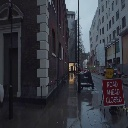

In [17]:
video = cv2.VideoCapture("short_walk.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    # resize to 512x512
    frame = cv2.resize(frame, (128,128))
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

In [ ]:
# OpenAI API Key
api_key = 'API KEY'

PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            #"These are frames from a person walking. Generate a compelling description that would help a blind person walk in the street.",
            #"These are frames from a person walking. Generate a description of what you see that would help a blind person walk in the street.",
            "These are frames from a person walking. Describe the obstacles in the street and tell the relative position.",
            *map(lambda x: {"image": x}, base64Frames[0::30]),
            #base64Frames[225]
        ],
    },
]

params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": api_key,
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 500,
}

result = openai.ChatCompletion.create(**params)
print(result.choices[0].message.content)